In [1]:
!conda install -c conda-forge yellowbrick -y
!conda install -c conda-forge phik -y

/ Collecting package metadata (current_repodata.json): done
Solving environment: - ^C
failed with initial frozen solve. Retrying with flexible solve.

CondaError: KeyboardInterrupt



# North American Mushroom Ediblity Classification

(write problem understanding here)
(problem: want to determine rules for deciding if a mushroom is poisonous; should be easy to remember)

## Objectives
- Using Machine Learning, derive easy to remember/utilize decision rules to determine if a mushroom is poisonous
- Should not restrain from using high cardinality features (might be difficult to remember), or features where the levels are difficult to distinguish (unless it being difficult to distinguish does not matter e.g. two similar features tend to be poisonous anyways)
- Should not be overly complicated (easily interpretable by humans). Hence should refrain from using black box models, and limit the complexity. A absolutely perfect model that is overly complicated would be completely useless in the field.
- Should match or exceed human level performance. If perfect accuracy is not attainable, prioritize recall (mushroom is poisonous, but is wrongly classified as being edible). 
- Prioritize Tree based models which give a distinct answer rather than something like Logistic Regression which gives probabilistic outputs.
| Optimizing Metric | Satisficing Metrics |
|---|---|
| Accuracy | Model must be easily interpretable, preferably tree based model |
| | Max depth of tree based models < 10 |
| | Recall (True Positive Rate) > 98% |


### Defining Human Level Performance 
- We define human level performance to gain an estimate of the bayes optimal error, the best result attainable for a classification model.
- In a article published in Feburary 2020, the US Agricultural Research Service developed a portable test to detect if a mushroom is poisonous. https://www.mdpi.com/2072-6651/12/2/123/htm
- Hence, we define the target we want to match/exceed as the result of the test:

    | Accuracy | True Positive Rate | True Negative Rate |
    |----|----|----|
    | 94.6% | 92.3% | 100% |

In [128]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import json
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, get_scorer, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from yellowbrick.model_selection import learning_curve
from sklearn.inspection import permutation_importance


import phik # phi k correlation 
from phik.report import plot_correlation_matrix, correlation_report
sns.set()

from typing import Union, Tuple, List

In [3]:
dataframe = pd.core.frame.DataFrame

## Importing the Data 
The data format is a comma delimited file. The raw data is provided, without the column names provided as the first row. Hence, column names are manually specified based on the dataset info (`agaricus-lepiota.names`) file. From the dataset info, we also note that null values are denoted by the `?` symbol, and that there are 2480 missing values, all from the **stalk-root** column. 

In [4]:
col_names = [
    "class",
    "cap-shape",
    "cap-surface",
    "cap-color",
    "bruises?",
    "odor",
    "gill-attachment",
    "gill-spacing",
    "gill-size",
    "gill-color",
    "stalk-shape",
    "stalk-root",
    "stalk-surface-above-ring",
    "stalk-surface-below-ring",
    "stalk-color-above-ring",
    "stalk-color-below-ring",
    "veil-type",
    "veil-color",
    "ring-number",
    "ring-type",
    "spore-print-color",
    "population",
    "habitat"
]
mush_df = pd.read_csv("data/agaricus-lepiota.data", header=None, names = col_names, na_values="?")
mush_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises?                  8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                5644 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

### Improving Data Readability
Each attribute in the data is currently represented by a single letter. As this can make understanding the data more difficult, we will rename the attributes to be more human readable. I will import a mapping from each letter to the full name of the value.

In [5]:
with open('data/value_map.json') as json_file:
    value_map = json.load(json_file)
    mush_df = mush_df.replace(value_map)
mush_df.head()

,class,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,poisonous,convex,smooth,brown,t,pungent,free,close,narrow,black,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
1,edible,convex,smooth,yellow,t,almond,free,close,broad,black,...,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
2,edible,bell,smooth,white,t,anise,free,close,broad,brown,...,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows
3,poisonous,convex,scaly,white,t,pungent,free,close,narrow,brown,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
4,edible,convex,smooth,gray,f,none,free,crowded,broad,black,...,smooth,white,white,partial,white,one,evanescent,brown,abudant,grasses


## Data Understanding
We take reference from the Audubon Society Field Guide to North American Mushrooms, which is where the dataset was collected from, to understand what each feature represents.
### Odor

### Color
- A color guide is provided in the reference book.

### Spore Prints
- According to the reference book, spores of a mushroom are too small to be visible without a microscope
- Hence, seeing spore print color requires placing the mushroom on a piece of white paper, and seeing what color the paper turns
- This may take a long time (possibly hours), depending on the mushroom
- **Conclusion: Avoid, as much as possible, using any spore based features, as it is not practical to collect this data in the field.**


## Data Exploration

### Initial Questions for EDA
- Are the classes in the target label balanced?
- What does the frequency distribution for each categorical feature look like? 
- Are there any features with low variance (e.g. always the same value)?
- Are the missing values in the stalk-root column missing at random?
- Which categorical features have the high Cramer's V correlation with the target?
- What evaluation metric would be most suited for the data and problem?

In [6]:
mush_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises?                  8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                5644 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [7]:
mush_df.describe().T

,count,unique,top,freq
class,8124,2,edible,4208
cap-shape,8124,6,convex,3656
cap-surface,8124,4,scaly,3244
cap-color,8124,10,brown,2284
bruises?,8124,2,f,4748
odor,8124,9,none,3528
gill-attachment,8124,2,free,7914
gill-spacing,8124,2,close,6812
gill-size,8124,2,broad,5612
gill-color,8124,12,buff,1728


### Looking at Categorical Value Distributions
To make the task of checking out the count distribution of the different columns easier, I've created a function to automatically create a sorted countplot, further separated by the class if necessary.

In [8]:
def show_cat_dist(df: dataframe, columns: Union[List[str], str], hue: Union[str, None] = None, figsize: Tuple[float, float] = (7, 20)):
    fig, ax = plt.subplots(len(columns) if type(columns) is list else 1, 1, figsize=figsize, tight_layout=True)
    if type(columns) is list:
        for idx, feature in enumerate(columns):
            counts = df[feature].value_counts().sort_values(ascending=False)
            ax[idx].set_title("Categorical Distribution of " + feature)
            if hue is None:
        #         sns.catplot(data=df, y=column, kind='bar')
                sns.countplot(y=feature, data=df, order= counts.index, ax = ax[idx])
            else:
        #         sns.catplot(data=df, y=column, hue=hue, kind='bar')
                sns.countplot(y=feature, hue=hue,data=df,order=counts.index, ax = ax[idx])
    else:
            counts = df[columns].value_counts().sort_values(ascending=False)
            ax.set_title("Categorical Distribution of " + columns)
            if hue is None:
        #         sns.catplot(data=df, y=column, kind='bar')
                sns.countplot(y=columns, data=df, order= counts.index, ax = ax)
            else:
        #         sns.catplot(data=df, y=column, hue=hue, kind='bar')
                sns.countplot(y=columns, hue=hue,data=df,order=counts.index, ax = ax)
    return fig, counts


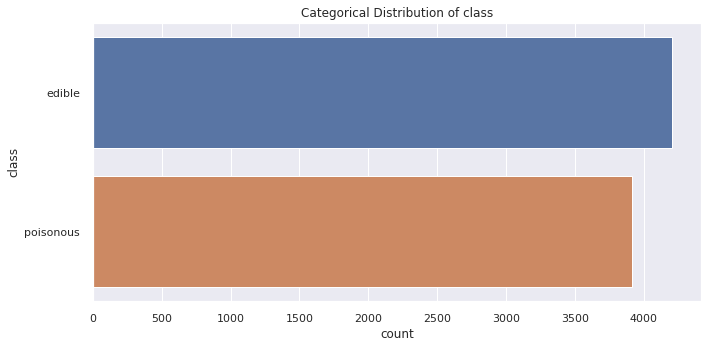

In [9]:
fig, counts = show_cat_dist(mush_df, "class", figsize=(10, 5))

In [10]:
mush_df["class"].value_counts()

edible       4208
poisonous    3916
Name: class, dtype: int64

In [11]:
4208 - 3916

292

There is a relatively even class balance between poisonous and edible mushrooms, with there being 292 more edible mushrooms in the entire dataset as compared to poisonous mushrooms. 

#### General Features

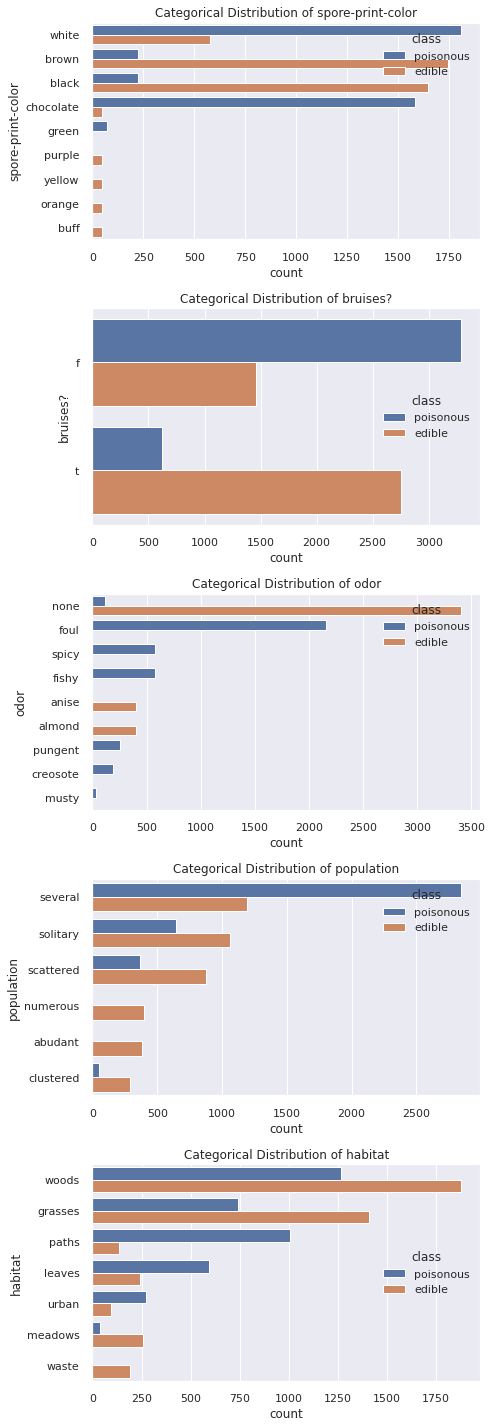

In [12]:
general_features = ['spore-print-color', 'bruises?', 'odor', 'population', 'habitat']

fig, counts = show_cat_dist(mush_df, general_features, "class")

fig.show()

#### Mushroom Cap Features

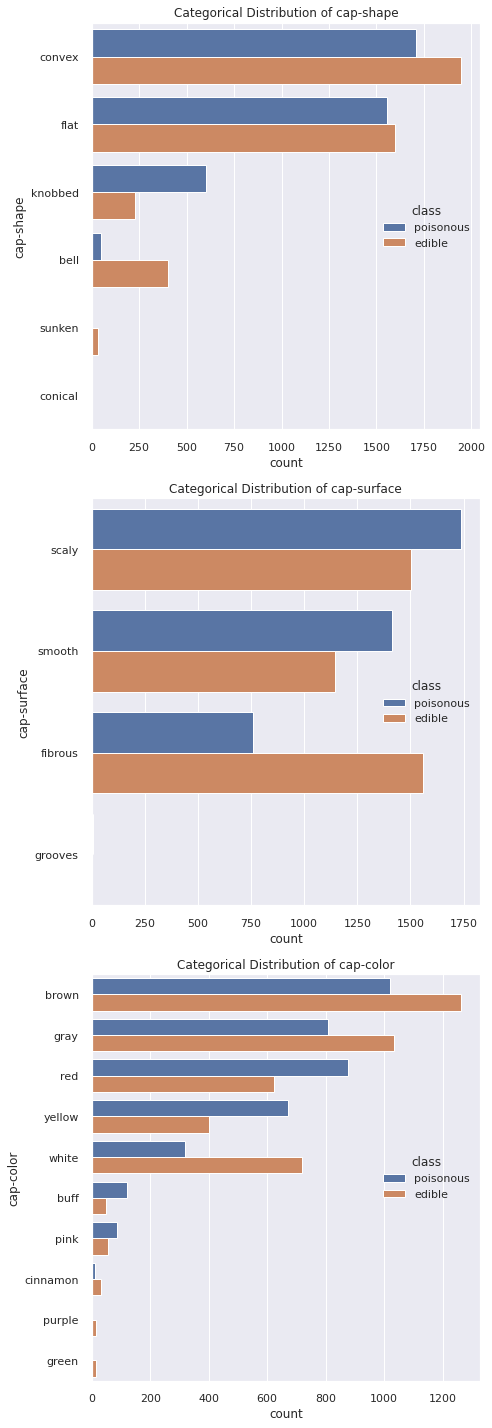

In [13]:
cap_features = ['cap-shape', 'cap-surface', 'cap-color']
fig, counts = show_cat_dist(mush_df, cap_features, "class")

fig.show()

#### Gill Features

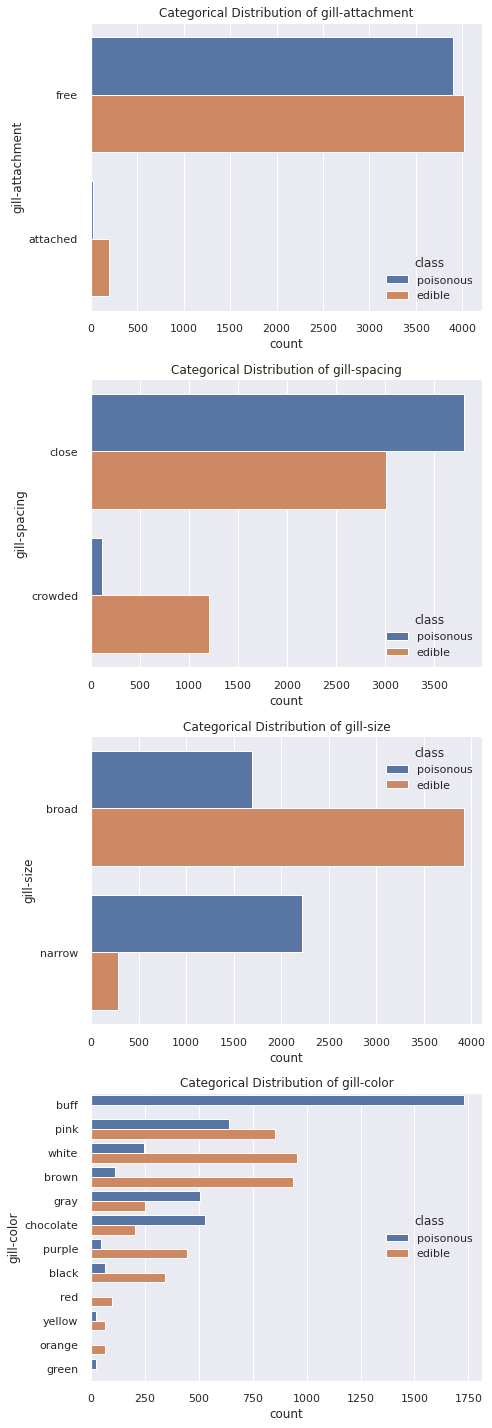

In [14]:
gill_features = ['gill-attachment', 'gill-spacing', 'gill-size', 'gill-color']
fig, counts = show_cat_dist(mush_df, gill_features, "class")

fig.show()

#### Stalk Features

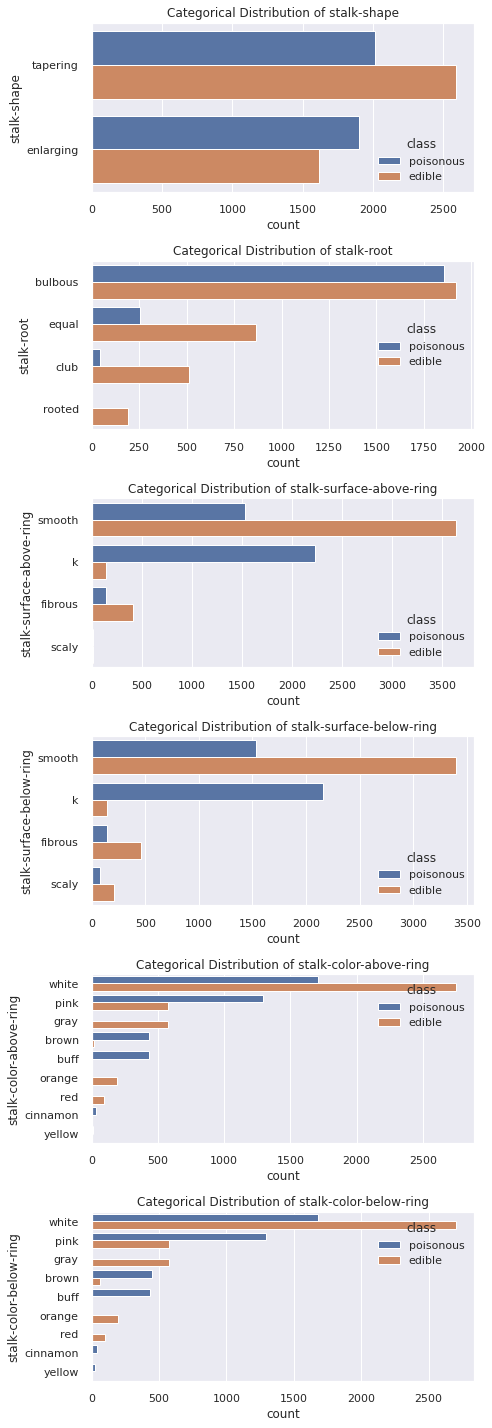

In [15]:
stalk_features = ['stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring']
fig, counts = show_cat_dist(mush_df, stalk_features, "class")

fig.show()

#### Veil Features

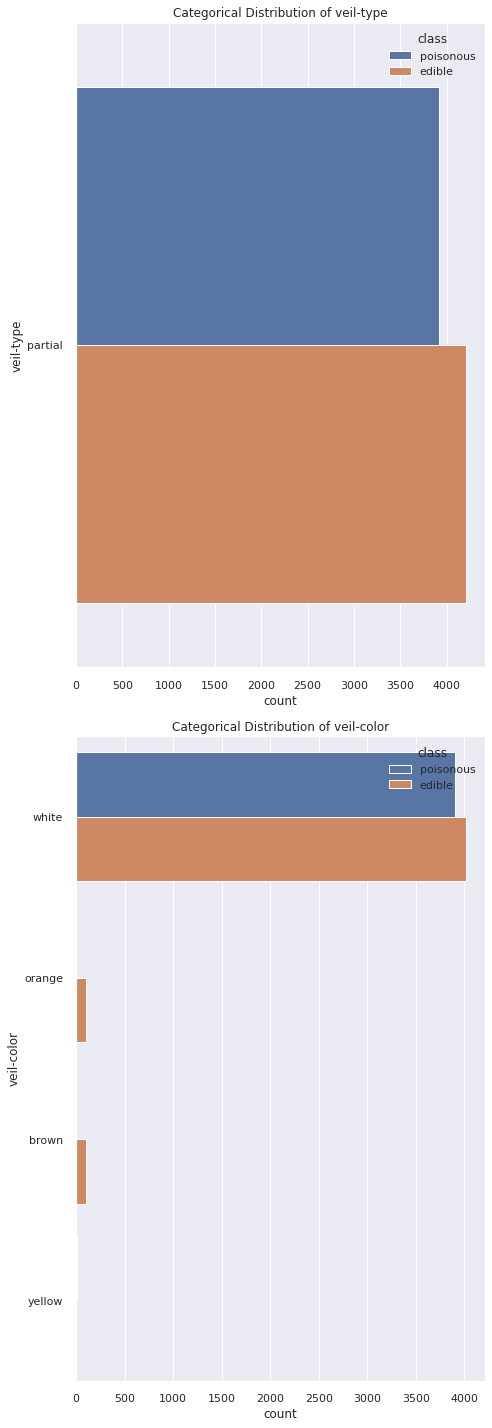

In [16]:
veil_features = ['veil-type', 'veil-color']
fig, counts = show_cat_dist(mush_df, veil_features, "class")

fig.show()

#### Ring Features

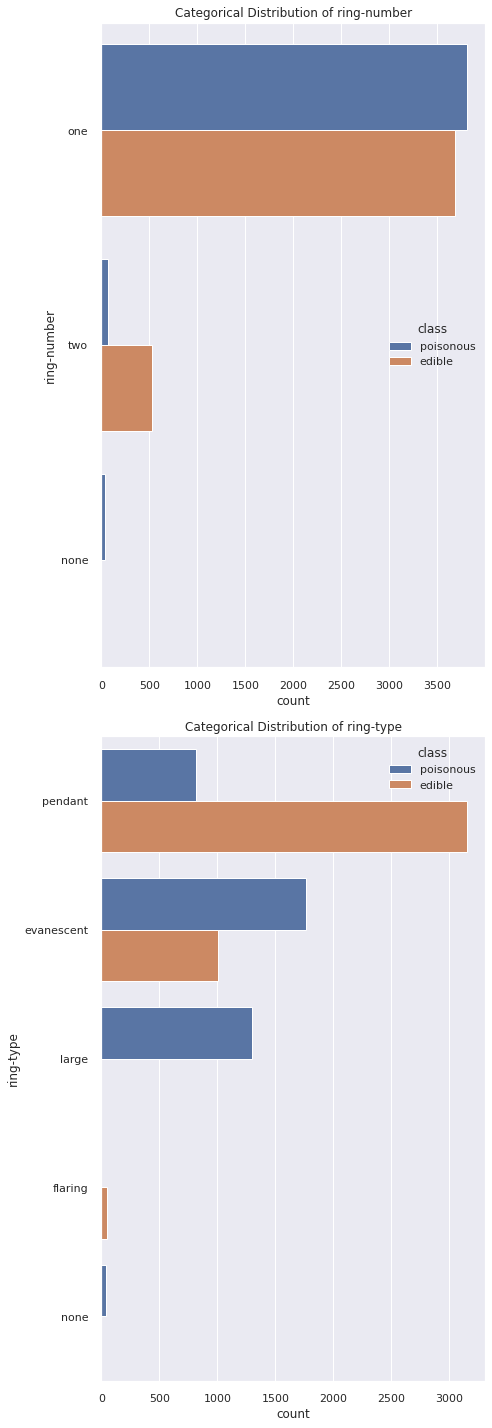

In [17]:
ring_features = ['ring-number',
       'ring-type']
fig, counts = show_cat_dist(mush_df, ring_features, "class")

fig.show()

#### Summary of Insights From Checking the Distribution of Categorical Variables

### Checking for Low Variance Features

For later feature selection, we wish to know which features almost always have the same value, as it would limit the usefulness of the feature.

In [18]:
mush_df.apply(lambda x : (x.value_counts() / len(mush_df) * 100).max(), axis = 0).sort_values(ascending=False)

veil-type                   100.000000
veil-color                   97.538159
gill-attachment              97.415066
ring-number                  92.171344
gill-spacing                 83.850320
gill-size                    69.079271
stalk-surface-above-ring     63.712457
stalk-surface-below-ring     60.758247
bruises?                     58.444116
stalk-shape                  56.720827
stalk-color-above-ring       54.948301
stalk-color-below-ring       53.963565
class                        51.797144
population                   49.729197
ring-type                    48.842935
stalk-root                   46.479567
cap-shape                    45.002462
odor                         43.426883
cap-surface                  39.931068
habitat                      38.749385
spore-print-color            29.394387
cap-color                    28.114229
gill-color                   21.270310
dtype: float64

We observe that all mushrooms have the same veil type (also supported by our previous plots), and that most mushrooms have the same veil color, gill attachment, ring number and gill spacing.

### Checking Relationships Between Features and Target
To check correlation between the features and target, we make use of $\phi_k$ correlation, which has native support for nominal variables. The reason why we choose this over other measures of correlation like Pearson's r or $\chi^2$ is because:
- For a $\chi^2$ test, when the degrees of freedom is extremely high (as is the case when we have so many features), the chi squared values tend to be extremely large. Hence it becomes harder to interpret the values obtained as every feature would appear important.
- While Pearson correlation can calculate correlation between dichotomous categorical variables, it has been mostly designed for interval variables. To calculate correlation for nominal categorical variables, we need to one hot encode the data, which would make the resulting correlation plot extremely hard to read due to it's large size 

In [90]:
phik_overview = mush_df.phik_matrix().sort_values("class", ascending=False)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/phik/data_quality.py:80: UserWarning: Not enough unique value for variable veil-type for analysis 1. Dropping this column
  .format(col, df[col].nunique())


In [96]:
phik_overview.nlargest(10, "class")

,class,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
class,1.000000,0.339560,0.294330,0.281663,0.708427,0.931449,0.199636,0.519680,0.749777,0.838625,...,0.795807,0.783006,0.522229,0.512312,0.229215,0.129640,0.496840,0.737545,0.665121,0.410200
odor,0.931449,0.452134,0.358378,0.607339,0.653013,1.000000,0.260271,0.428422,0.744987,0.700349,...,0.583373,0.675120,0.862285,0.859799,0.155551,0.952736,0.846142,0.819423,0.630450,0.597233
gill-color,0.838625,0.524641,0.506619,0.568713,0.807167,0.700349,0.926703,0.416612,0.929546,1.000000,...,0.649711,0.680309,0.731246,0.727520,0.764312,0.723609,0.730589,0.787076,0.780714,0.719181
stalk-surface-above-ring,0.795807,0.242318,0.350663,0.407822,0.783349,0.583373,0.139788,0.628530,0.254215,0.649711,...,1.000000,0.839322,0.683801,0.601291,0.695746,0.134823,0.526466,0.586382,0.464642,0.417704
stalk-surface-below-ring,0.783006,0.168853,0.407656,0.495496,0.774913,0.675120,0.185772,0.600232,0.225441,0.680309,...,0.839322,1.000000,0.622198,0.631167,0.292244,0.267124,0.591786,0.589179,0.470218,0.429951
gill-size,0.749777,0.479438,0.412216,0.606414,0.547950,0.744987,0.168185,0.167915,1.000000,0.929546,...,0.254215,0.225441,0.364941,0.346026,0.169454,0.117523,0.469395,0.652801,0.702558,0.465152
spore-print-color,0.737545,0.460748,0.350068,0.545442,0.606991,0.819423,0.803236,0.307347,0.652801,0.787076,...,0.586382,0.589179,0.836237,0.832583,0.669123,0.653267,0.742690,1.000000,0.533221,0.543044
bruises?,0.708427,0.353524,0.200454,0.280636,1.000000,0.653013,0.212208,0.452514,0.547950,0.807167,...,0.783349,0.774913,0.481338,0.490808,0.199829,0.041795,0.639604,0.606991,0.415869,0.494364
population,0.665121,0.576710,0.390325,0.517833,0.415869,0.630450,0.570228,0.864630,0.702558,0.780714,...,0.464642,0.470218,0.680276,0.676804,0.342064,0.738902,0.470283,0.533221,1.000000,0.694694
stalk-color-above-ring,0.522229,0.401862,0.378182,0.530818,0.481338,0.862285,0.938937,0.399950,0.364941,0.731246,...,0.683801,0.622198,1.000000,0.949868,0.896146,0.963143,0.830963,0.836237,0.680276,0.651509


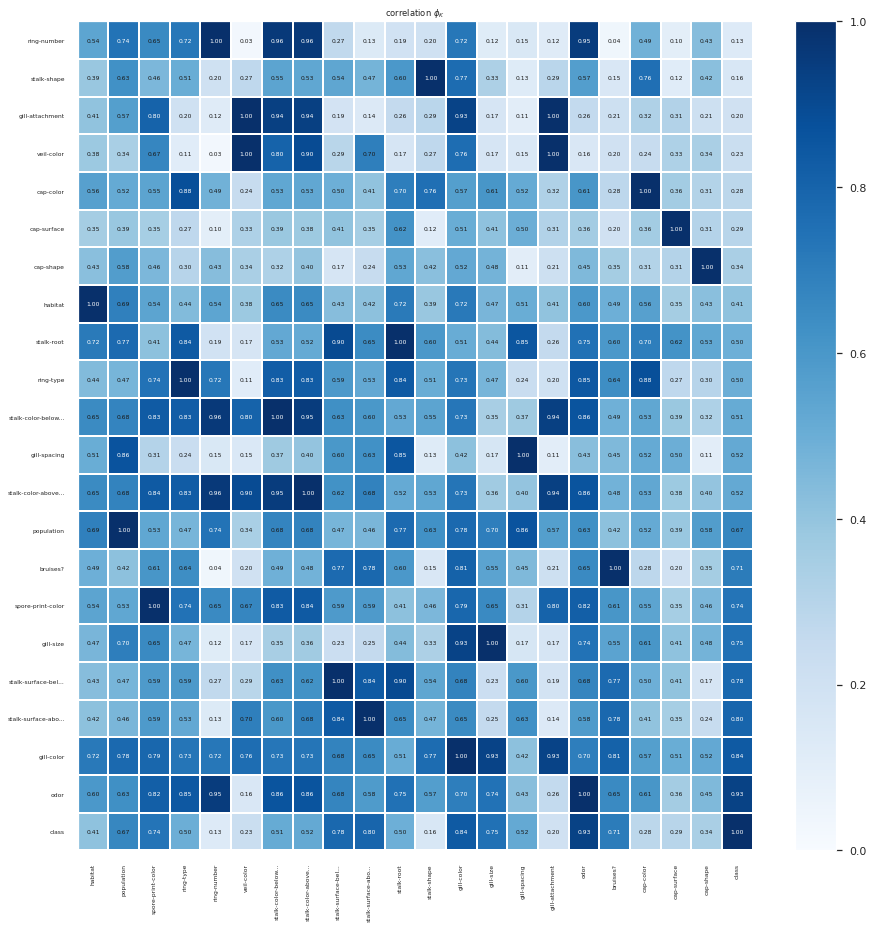

In [98]:
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=0.6,
                        figsize=(13,13))
plt.tight_layout()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/phik/data_quality.py:80: UserWarning: Not enough unique value for variable veil-type for analysis 1. Dropping this column
  .format(col, df[col].nunique())
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/phik/phik.py:250: RuntimeWarning: invalid value encountered in sqrt
  global_correlations = np.array([[np.sqrt(1 - 1/(V[i][i] * Vinv[i][i]))] for i in range(V.shape[0])])


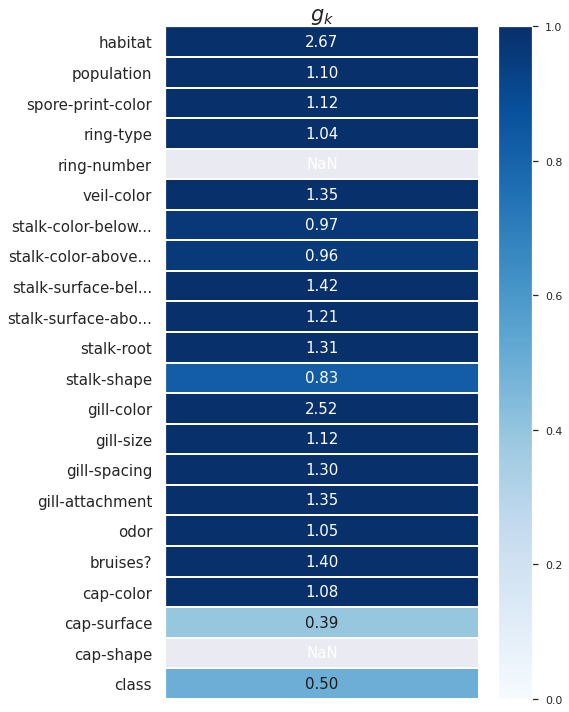

In [101]:
global_correlation, global_labels = mush_df.global_phik()
plot_correlation_matrix(global_correlation, x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1, figsize=(8,10),
                        color_map='Blues', title=r'$g_k$',
                        fontsize_factor=1.5)
plt.tight_layout()

## Data Preprocessing

### Separate Features and Labels
We start by separating the features and the labels. A label encoder is used to encode the labels as 1 (poisonous) and 0 (non-poisonous)

In [19]:
X, y = mush_df.drop('class', axis = 1), mush_df["class"]
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

### Splitting Data into Training and Test Set

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 42)

### Data Preprocessing Pipeline: One-Hot Encoding

For our initial strategy, since all the features are nominal features, we one-hot encode them. Due to the high cardinality of some features, and the overall large number of features, this will greatly increase the dimensionality of our data. Hence, it may be necessary to perform feature selection later on to reduce the risk of overfitting due to the curse of dimensionality.

In [21]:
data_preprocess_steps = [
    ('Imputer', SimpleImputer(strategy='most_frequent')), # impute missing values with most frequent value
    ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore')) # one hot encode categorical data. We don't drop for other catergorical features as we want to make the features more interpretible (at cost to having extra dimensions in the data)
]
data_preprocessing = Pipeline(data_preprocess_steps)

## Modelling: Initial Baseline Model

In [31]:
from sklearn.dummy import DummyClassifier
clf = Pipeline(data_preprocess_steps + [
    ('Baseline Model', DummyClassifier(strategy="most_frequent"))
])

## Model Evaluation
To standardize the way the model is evaluated, we will create a function to automatically evaluate the model. 

It will:
- Get the score of the model on the cross-validation set.
- Get the score of the model on the hold-out set.
- Generate the learning curve of the candidate model.
- Generate a confusion matrix
- Plot ROC Curve
- Return the trained model (trained on the entire training set), if specified

In [43]:
def evalCandidateModel(model, X_train, X_test, y_train, y_test, scoring = 'accuracy', cv = 5):
    fig, ax = plt.subplots(2, 2, figsize=(12, 12), tight_layout=True)
    scores = cross_validate(model, X_train, y_train, scoring=scoring, return_estimator=True, return_train_score=True, cv=cv)
    best_estimator = scores["estimator"][np.argmax(scores["test_score"])]
    del scores["estimator"]
    scores = pd.DataFrame(scores)
      # If a hold out set is provided
    if X_test is not None and y_test is not None:
        scorer = get_scorer(scoring) # Then also score it, based off the scoring scheme provided
        scores["hold_out_score"] = scorer(best_estimator, X_test, y_test)
        y_pred = best_estimator.predict(X_test)
        report = classification_report(y_test, y_pred)
        matrix = confusion_matrix(y_test, y_pred)
        plot_roc_curve(best_estimator, X_test, y_test, ax=ax[0, 1])
        plot_precision_recall_curve(best_estimator, X_test, y_test, ax=ax[1, 1])
        sns.heatmap(matrix, ax=ax[1, 0], annot=True, fmt="d")
        
    lr = learning_curve(model, X_train, y_train, scoring = scoring, n_jobs=-1, random_state = 42, cv =cv, show = False, ax=ax[0, 0])
#     for axes in ax.flat:
#         axes.ticklabel_format(useOffset=False)
    return scores.describe().iloc[1:3, 2:].round(5), report, fig, best_estimator


In [24]:
def evalHistory(new_score, model_name, history = None):
    if history is None:
        history = pd.DataFrame()
    new_score =new_score.iloc[0, :]
    new_score.rename(index=model_name, inplace=True)
    history = history.append(new_score)
    return history

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

,test_score,train_score,hold_out_score
mean,0.51777,0.51777,0.51877
std,0.00018,0.00004,0.00000


              precision    recall  f1-score   support

           0       0.52      1.00      0.68       843
           1       0.00      0.00      0.00       782

    accuracy                           0.52      1625
   macro avg       0.26      0.50      0.34      1625
weighted avg       0.27      0.52      0.35      1625



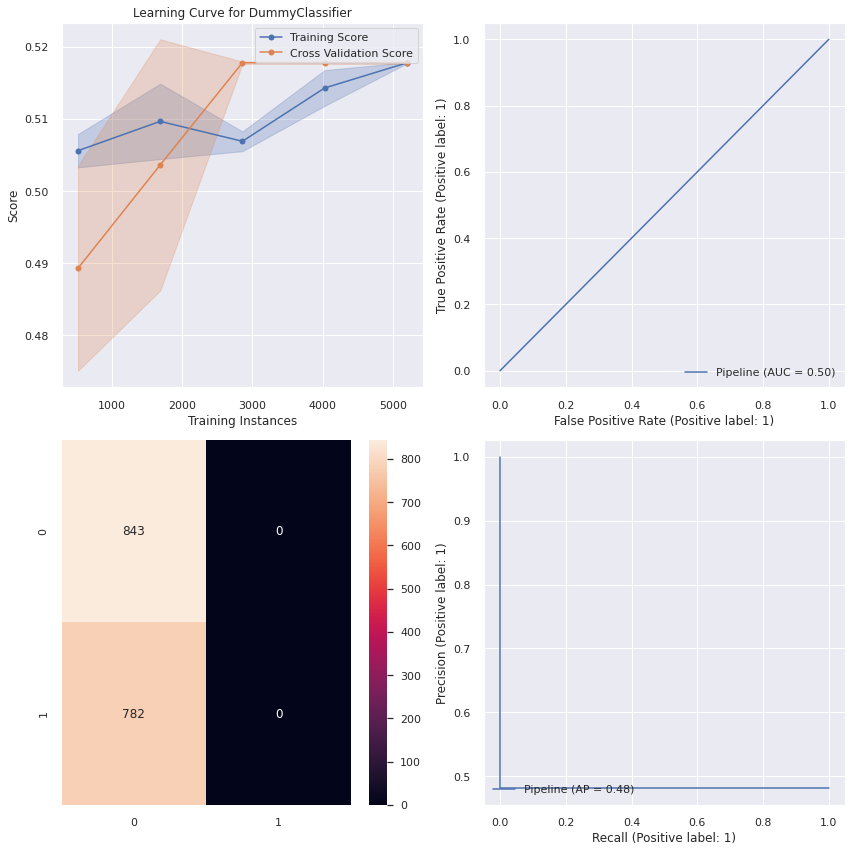

In [44]:
scores, report, fig, baseline = evalCandidateModel(clf, X_train, X_test, y_train, y_test)
history = evalHistory(scores, "Baseline (Mode Predictor)")
display(scores)
print(report)

In [27]:
history

,hold_out_score,test_score,train_score
Baseline (Mode Predictor),0.51877,0.51777,0.51777


The baseline classifier is effectively equivilent to flipping a coin to decide if the mushroom is poisonous (random guessing), due to the relatively even class balance in the dataset.

## Modelling: Decision Tree

In [49]:
from sklearn.tree import DecisionTreeClassifier
clf = Pipeline(data_preprocess_steps + [
    ('Baseline Model', DecisionTreeClassifier(max_depth=5))
])

,test_score,train_score,hold_out_score
mean,0.99831,0.99888,1.0
std,0.00138,0.00115,0.0


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       843
           1       1.00      1.00      1.00       782

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



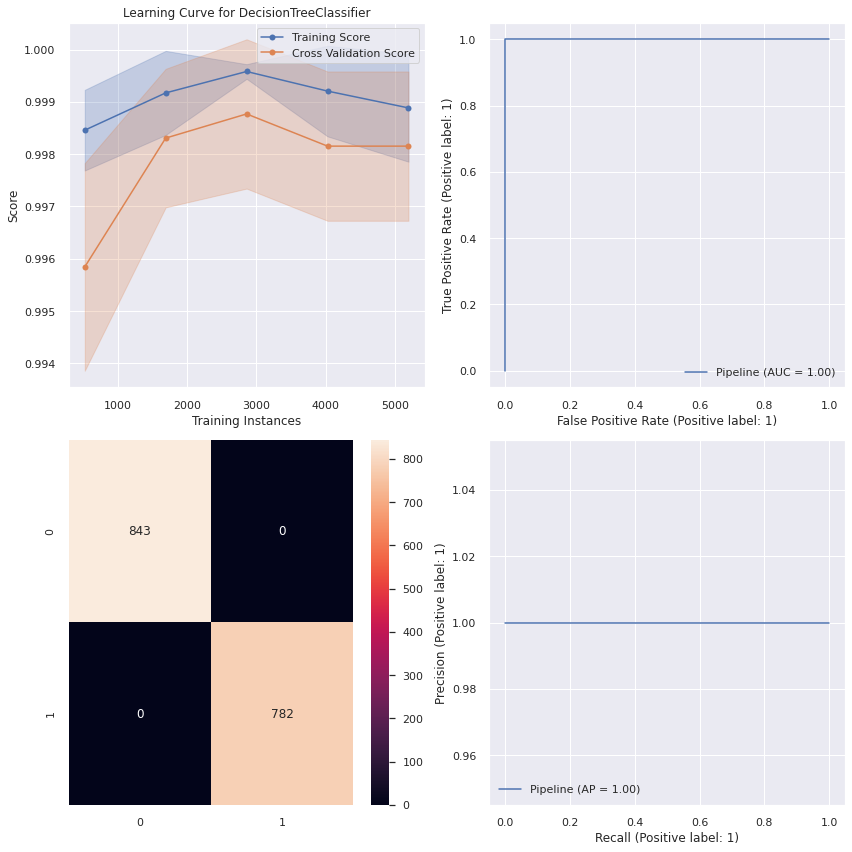

In [50]:
scores,report, fig, dt = evalCandidateModel(clf, X_train, X_test, y_train, y_test)
history = evalHistory(scores, "Decision Tree (Max Depth = 5)", history)
display(scores)
print(report)

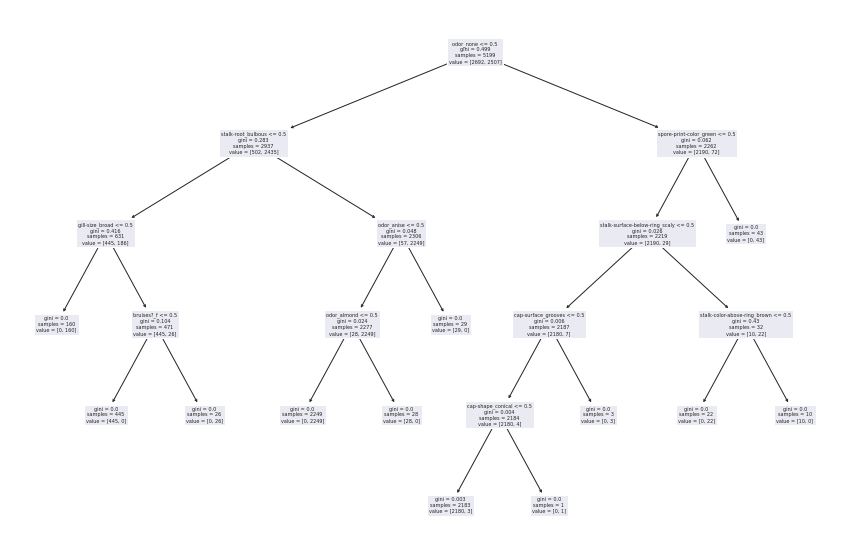

In [79]:
tree = dt[-1]
feature_names = dt[-2].get_feature_names(X.columns)
from sklearn.tree import plot_tree 
plt.figure(figsize=(15, 10))
plt_tree = plot_tree(tree, feature_names=feature_names)

In [80]:
clf = Pipeline(data_preprocess_steps + [
    ('Baseline Model', DecisionTreeClassifier(max_depth=2))
])

,test_score,train_score,hold_out_score
mean,0.94999,0.95211,0.944
std,0.00382,0.00503,0.000


              precision    recall  f1-score   support

           0       0.98      0.91      0.94       843
           1       0.91      0.98      0.94       782

    accuracy                           0.94      1625
   macro avg       0.95      0.95      0.94      1625
weighted avg       0.95      0.94      0.94      1625



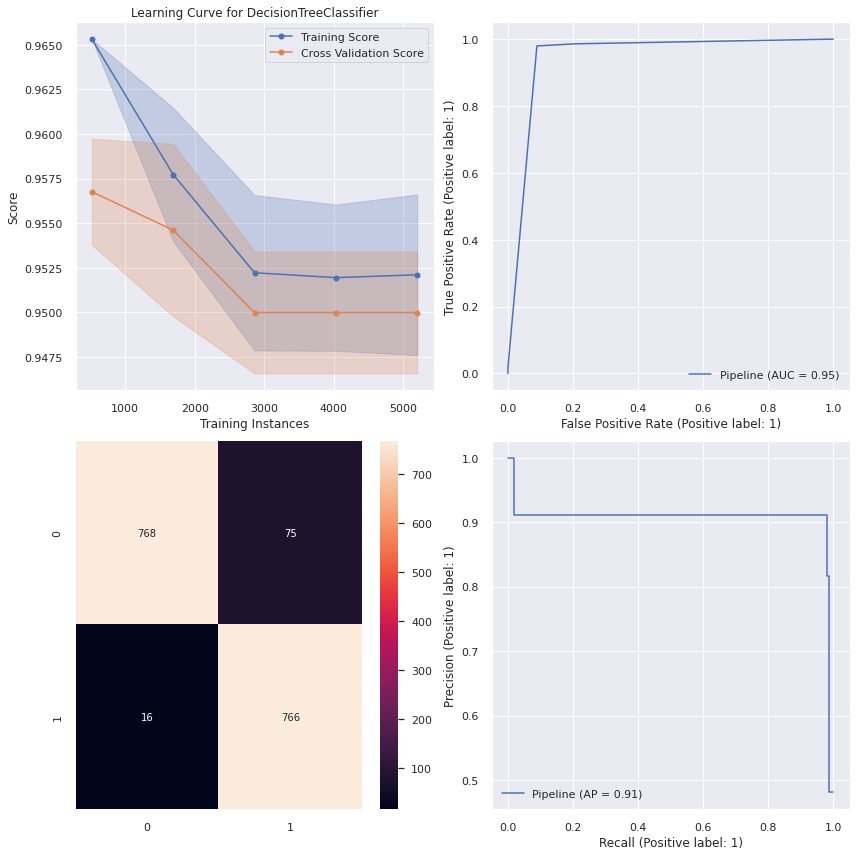

In [81]:
scores,report, fig, dt = evalCandidateModel(clf, X_train, X_test, y_train, y_test)
history = evalHistory(scores, "Decision Tree (Max Depth = 2)", history)
display(scores)
print(report)

A simple decision tree with a max depth of 2 significantly outperforms random guessing, having an accuracy on the cross validation set of 94.99%. The recall on poisonious mushrooms is also promising, at 98%.

In [82]:
history

,hold_out_score,test_score,train_score
Baseline (Mode Predictor),0.51877,0.51777,0.51777
Decision Tree,0.94400,0.94999,0.95211
Decision Tree (Max Depth = 5),1.00000,0.99831,0.99888
Decision Tree (Max Depth = 2),0.94400,0.94999,0.95211


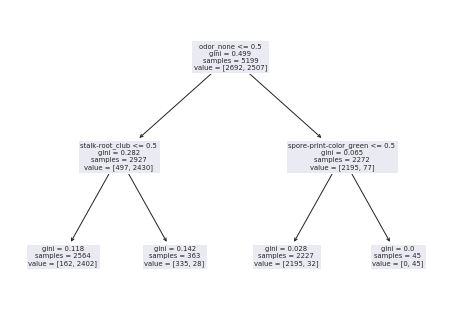

In [48]:
tree = dt[-1]
feature_names = dt[-2].get_feature_names(X.columns)
from sklearn.tree import plot_tree 
plt_tree = plot_tree(tree, feature_names=feature_names)


When plotting out the decision tree, we see that it makes its initial split based off the lack of odor of the mushroom. Then, it either looks at the stalk root or the spore print color to decide if the mushroom is poisonous. 

### Next Steps
To attain a accurate model with high interpretibilty, we may wish to attempt these options
- Remove low variance categorical features 
- Use a measure like Phi-k to calculate correlations, and use correlation to select features
- Use feature importances from random forests to select features
- Perform feature engineering, by merging together values

In [103]:
X

,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,convex,smooth,brown,t,pungent,free,close,narrow,black,enlarging,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
1,convex,smooth,yellow,t,almond,free,close,broad,black,enlarging,...,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
2,bell,smooth,white,t,anise,free,close,broad,brown,enlarging,...,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows
3,convex,scaly,white,t,pungent,free,close,narrow,brown,enlarging,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
4,convex,smooth,gray,f,none,free,crowded,broad,black,tapering,...,smooth,white,white,partial,white,one,evanescent,brown,abudant,grasses
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,knobbed,smooth,brown,f,none,attached,close,broad,yellow,enlarging,...,smooth,orange,orange,partial,orange,one,pendant,buff,clustered,leaves
8120,convex,smooth,brown,f,none,attached,close,broad,yellow,enlarging,...,smooth,orange,orange,partial,brown,one,pendant,buff,several,leaves
8121,flat,smooth,brown,f,none,attached,close,broad,brown,enlarging,...,smooth,orange,orange,partial,orange,one,pendant,buff,clustered,leaves
8122,knobbed,scaly,brown,f,fishy,free,close,narrow,buff,tapering,...,k,white,white,partial,white,one,evanescent,white,several,leaves


We start by removing features with low variance

In [116]:
low_variance_features = X_train.apply(lambda x : (x.value_counts() / len(X_train) * 100).max(), axis = 0).sort_values(ascending=False).nlargest(5).index
low_variance_features

Index(['veil-type', 'veil-color', 'gill-attachment', 'ring-number',
       'gill-spacing'],
      dtype='object')

In [119]:
X_train = X_train.drop(low_variance_features, axis = 1)
X_test = X_test.drop(low_variance_features, axis = 1)

In [122]:
data_preprocess_steps = [
    ('Imputer', SimpleImputer(strategy='most_frequent')), # impute missing values with most frequent value
    ('OrdinalEncoder', OrdinalEncoder(handle_unknown='ignore')) # ordinal encode data to allow hist gradient booster to process categorical features natively
]
data_preprocessing = Pipeline(data_preprocess_steps)

We make use of sklearn's implementation of LightGBM, which includes native support for nominal variables.

,test_score,train_score,hold_out_score
mean,1.0,1.0,1.0
std,0.0,0.0,0.0


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       843
           1       1.00      1.00      1.00       782

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



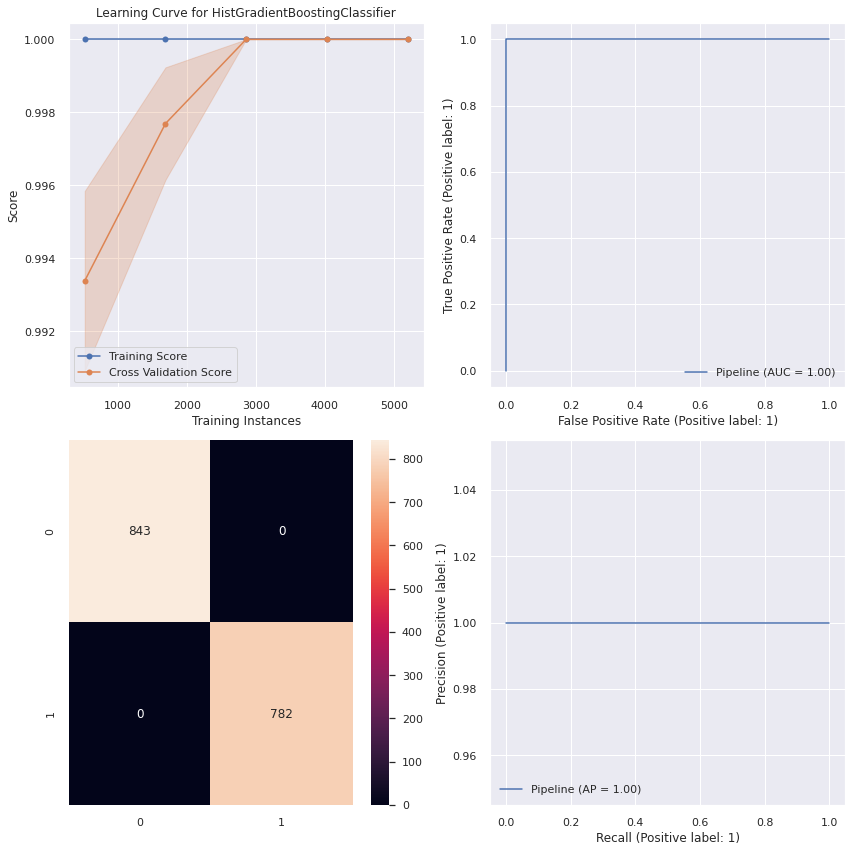

In [142]:
clf = Pipeline(data_preprocess_steps + [
    ('Gradient Boosted Trees Model', HistGradientBoostingClassifier(categorical_features = [True] * len(X_train.columns), max_depth = 5))
])
scores,report, fig, gbm = evalCandidateModel(clf, X_train, X_test, y_train, y_test)
history = evalHistory(scores, "LightGBM", history)
display(scores)
print(report)

#### Feature Importances
To calculate feature importances, we will make use of permutation based feature importance. This is because impurity based feature importances used in tree-based models are highly biased towards high cardinality features, and do not reflect the ability of the feature to be useful for generalization.

In [143]:
result = permutation_importance(gbm, X_test, y_test, n_repeats= 10, random_state = 42, n_jobs = -1)
result


{'importances_mean': array([0.00000000e+00, 0.00000000e+00, 4.92307692e-04, 0.00000000e+00,
        4.88676923e-01, 5.90769231e-03, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 6.15384615e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.37846154e-02, 4.30769231e-04,
        0.00000000e+00]),
 'importances_std': array([0.        , 0.        , 0.00024615, 0.        , 0.0131279 ,
        0.00138154, 0.        , 0.        , 0.        , 0.00018462,
        0.        , 0.        , 0.        , 0.        , 0.00132558,
        0.000282  , 0.        ]),
 'importances': array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.00061538, 0.00061538, 0.00061538, 0.00061538, 0.00061538,
         0.        , 0.00061538, 0.        , 0.

In [144]:
pd.DataFrame(np.array([result.importances_mean, result.importances_std]).T, columns=["Mean FI", "FI STD"], index=X_train.columns).sort_values("Mean FI", ascending = False)

,Mean FI,FI STD
odor,0.488677,0.013128
spore-print-color,0.013785,0.001326
gill-size,0.005908,0.001382
cap-color,0.000492,0.000246
population,0.000431,0.000282
stalk-surface-above-ring,0.000062,0.000185
cap-shape,0.000000,0.000000
stalk-color-above-ring,0.000000,0.000000
ring-type,0.000000,0.000000
stalk-color-below-ring,0.000000,0.000000


We note that odor has the highest mean decrease in accuracy when it's values are randomly shuffled, suggesting it is the most important feature. This is followed by spore-print-color, and gill size. The mean feature importance of odor is much higher than all other features. This suggests that this feature has the best generalization.

In [146]:
phik_overview.nlargest(10, "class")

,class,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
class,1.000000,0.339560,0.294330,0.281663,0.708427,0.931449,0.199636,0.519680,0.749777,0.838625,...,0.795807,0.783006,0.522229,0.512312,0.229215,0.129640,0.496840,0.737545,0.665121,0.410200
odor,0.931449,0.452134,0.358378,0.607339,0.653013,1.000000,0.260271,0.428422,0.744987,0.700349,...,0.583373,0.675120,0.862285,0.859799,0.155551,0.952736,0.846142,0.819423,0.630450,0.597233
gill-color,0.838625,0.524641,0.506619,0.568713,0.807167,0.700349,0.926703,0.416612,0.929546,1.000000,...,0.649711,0.680309,0.731246,0.727520,0.764312,0.723609,0.730589,0.787076,0.780714,0.719181
stalk-surface-above-ring,0.795807,0.242318,0.350663,0.407822,0.783349,0.583373,0.139788,0.628530,0.254215,0.649711,...,1.000000,0.839322,0.683801,0.601291,0.695746,0.134823,0.526466,0.586382,0.464642,0.417704
stalk-surface-below-ring,0.783006,0.168853,0.407656,0.495496,0.774913,0.675120,0.185772,0.600232,0.225441,0.680309,...,0.839322,1.000000,0.622198,0.631167,0.292244,0.267124,0.591786,0.589179,0.470218,0.429951
gill-size,0.749777,0.479438,0.412216,0.606414,0.547950,0.744987,0.168185,0.167915,1.000000,0.929546,...,0.254215,0.225441,0.364941,0.346026,0.169454,0.117523,0.469395,0.652801,0.702558,0.465152
spore-print-color,0.737545,0.460748,0.350068,0.545442,0.606991,0.819423,0.803236,0.307347,0.652801,0.787076,...,0.586382,0.589179,0.836237,0.832583,0.669123,0.653267,0.742690,1.000000,0.533221,0.543044
bruises?,0.708427,0.353524,0.200454,0.280636,1.000000,0.653013,0.212208,0.452514,0.547950,0.807167,...,0.783349,0.774913,0.481338,0.490808,0.199829,0.041795,0.639604,0.606991,0.415869,0.494364
population,0.665121,0.576710,0.390325,0.517833,0.415869,0.630450,0.570228,0.864630,0.702558,0.780714,...,0.464642,0.470218,0.680276,0.676804,0.342064,0.738902,0.470283,0.533221,1.000000,0.694694
stalk-color-above-ring,0.522229,0.401862,0.378182,0.530818,0.481338,0.862285,0.938937,0.399950,0.364941,0.731246,...,0.683801,0.622198,1.000000,0.949868,0.896146,0.963143,0.830963,0.836237,0.680276,0.651509


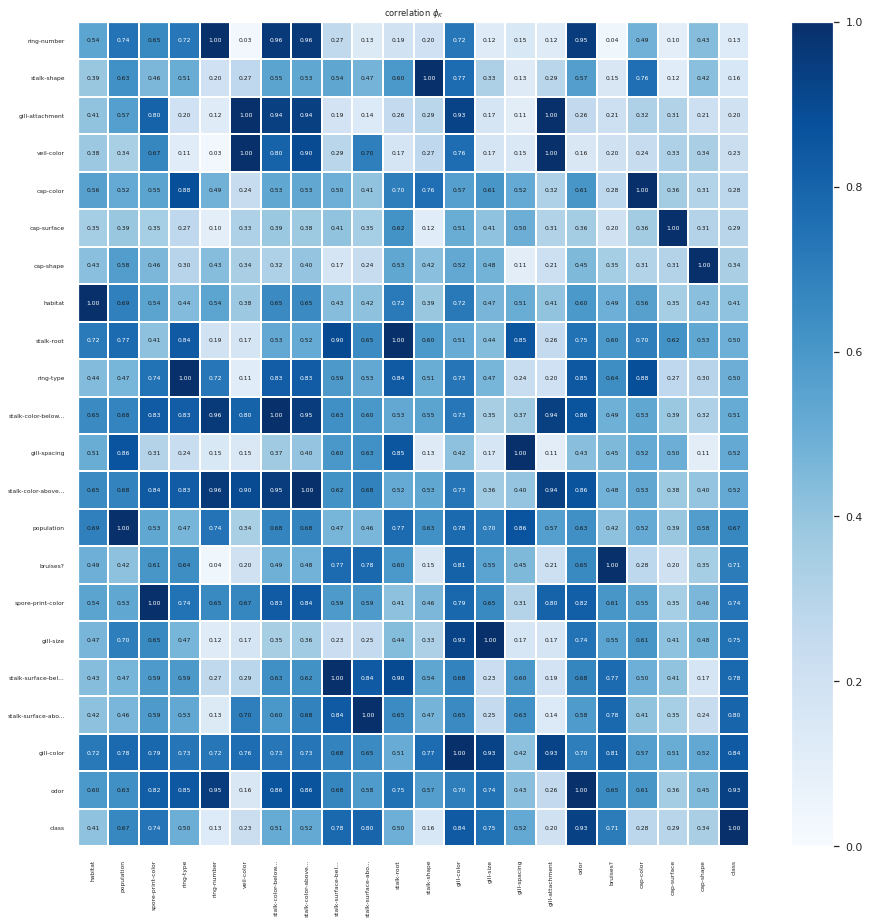

In [145]:
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=0.6,
                        figsize=(13,13))
plt.tight_layout()

Odor being the most important is also supported by our $\phi_k$ correlation matrix, in which odor has 0.93 correlation.

### Feature Selection
Based off these feature importances and the correlation matrix, we will restrict our features. We exclude spore print color, since from our background research, we've found that it is difficult to get spore print color.

In [ ]:
features = ["odor", "gill-color", "stalk-surface-above-ring", "stalk-surface-below-ring", "gill-size", "bruises?", "population"]

### Hyperparameter Tuning
- We will build a validation curve to determine the lowest complexity of the model needed to meet our initial objectives.